# Using Genetic Algorithm for Hyper Parameter Tuning

## Using data from the kaggle Housing Prices Competition for Kaggle Learn Users

Using multiple populations.

Competition URL: https://www.kaggle.com/c/home-data-for-ml-course

In [4]:
# Imports
import pandas as pd
import numpy as np
from numpy.random import default_rng
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import concurrent.futures
import random
import json
import os
import heapq
import time
import logging
import datetime

random_gen = default_rng()

In [5]:
# Data load
project_files_path = os.path.join("drive", "My Drive", "Colab Notebooks", "GA1")

train = pd.read_csv(os.path.join(project_files_path, "train.csv"))
X_test = pd.read_csv(os.path.join(project_files_path, "test.csv"))

X = train.drop(['SalePrice'], axis=1)
y = train.SalePrice

X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Preprocess data

numerical_columns = [col for col in X_train.columns if X_train[col].dtype != 'object']
categorical_columns = [col for col in X_train.columns if X_train[col].dtype == 'object']

most_frequent_num_imputer = SimpleImputer(strategy='most_frequent')
most_frequent_cat_imputer = SimpleImputer(strategy='most_frequent')

low_cardinality_cols = [col for col in categorical_columns if X_train[col].nunique() < 10]
high_cardinality_cols = set(categorical_columns) - set(low_cardinality_cols)
good_label_cols = [col for col in high_cardinality_cols if set(X_train[col]).issuperset(set(X_cv[col]))]

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

ordinal_encoder = OrdinalEncoder()

numerical_transformer = most_frequent_num_imputer

categorical_low_card_transformer = Pipeline(
    steps=[
           ('impute', most_frequent_cat_imputer),
           ('encode', OH_encoder)
    ]
)

categorical_high_card_transformer = Pipeline(
    steps=[
           ('impute', most_frequent_cat_imputer),
           ('encode', ordinal_encoder)
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
                  ('num', numerical_transformer, numerical_columns),
                  ('cat_low_card', categorical_low_card_transformer, low_cardinality_cols),
                  ('cat_high_card', categorical_high_card_transformer, good_label_cols)
    ]
)


X_train_prepped = preprocessor.fit_transform(X_train)
X_cv_prepped = preprocessor.transform(X_cv)
X_test_prepped = preprocessor.transform(X_test)

In [8]:
def model_from_hp(hp):
  return RandomForestRegressor(n_estimators=hp['n_estimators'],
                               criterion='mae',
                               max_depth=hp['max_depth'],
                               min_samples_split=hp['min_samples_split'],
                               min_samples_leaf=hp['min_samples_leaf'],
                               min_weight_fraction_leaf=hp['min_weight_fraction_leaf'],
                               max_features=hp['max_features'],
                               max_leaf_nodes=hp['max_leaf_nodes'],
                               min_impurity_decrease=hp['min_impurity_decrease'],
                               bootstrap=hp['bootstrap'],
                               oob_score=hp['oob_score'],
                               n_jobs=-1,
                               ccp_alpha=hp['ccp_alpha'],
                               max_samples=hp['max_samples'])

## Base Notebook: Alpha Male with Harem 

Alpha male: multiple populations (`n_territories=5, pop_size=30, n_survivors=15`),
the best individual parenting every ofspring.

Harem: the best individual is paired with every other survivor in a loop until population is full (requires the number of offsprings which is
`pop_size - n_survivors` to be >= n_survivors - 1 in order to guarantee all survivors parent offsprings.

Small step mutation: 0.01
Large step mutation: 0.1

v1.0:
* inserting evolving mutation rates as advised in:
Evolutionary computation: An overview
Mitchell, Melanie; Taylor, Charles E. Annual Review of Ecology and Systematics; Palo Alto Vol. 30,  (1999): 593.

* Also removing drifts because previous data indicates lack of correlation between being the territory with the best fitness (MAE) value and having the best chance to find a new best fitness value.

v1.3
* Change the n_estimators gene to have hard limits - to never receive values outside the limits. This is to avoid extremely long runtimes such as over two hours for a generation.

v1.5
* Change all genes to have hard limits.

**************************************************************************************************** 
Generation 12/500 2020-10-05 18:21:57.086484 time is 3 hours late
........................................................
Best MAE for territory 2 is 16333.710090253997 . Average improvement is 0.013385860797706872
......................
Best MAE for territory 3 is 25130.20487703362 . Average improvement is 0.0005622209725273386
...................................................
Best MAE for territory 0 is 17133.102623597348 . Average improvement is 0.0006601519608617767
.......
Best MAE for territory 1 is 17555.10007969329 . Average improvement is 0.041187440073424675
............
Best MAE for territory 4 is 16515.271738940755 . Average improvement is 0.0031303183800135415
This generation took 2:34:29 to process.
Remaining 487 generations and approximately 1117:40:12
Average improvement for generation: 0.01178519843690684 . Average total improvement: 0.8832423987125368
Total runtime

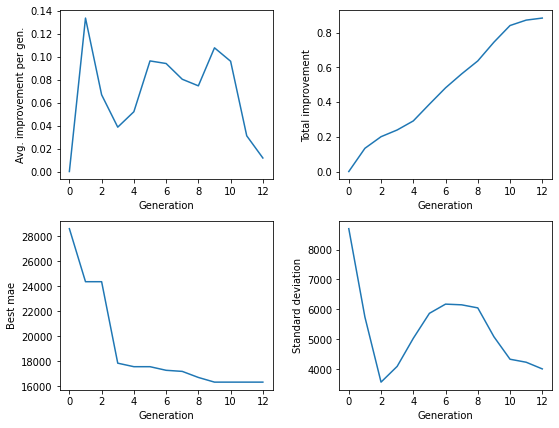

**************************************************************************************************** 
Generation 13/500 2020-10-05 20:56:27.685511 time is 3 hours late
...............

In [ ]:
# Hyper parameter tuning (using a genetic algorithm)

n_features = X_train_prepped.shape[1]
n_samples = X_train_prepped.shape[0]
pop_size = 30
n_generations = 500
n_territories = 5
n_survivors = 15
drift_threshold = 0.0

param_limits = {
    'n_estimators':             (1, 1000),
    'max_depth':                (1, n_features),
    'min_samples_split':        (2, 1000),
    'min_samples_leaf':         (1, 1000),
    'min_weight_fraction_leaf': (0, 0.5),
    'max_features':             (1, n_features),
    'max_leaf_nodes':           (2, 10000),
    'min_impurity_decrease':    (0, 1),
    'bootstrap':                (True, False),
    'oob_score':                (True, False),
    'ccp_alpha':                (0, 1),
    'max_samples':              (1, n_samples),
    'small_step_mutation':      (0, 1),
    'large_step_mutation':      (0, 1),
}

"""
Format of ecosystem is:
{
  'last_generation': int,
  'times': [float,...],
  'improvements': [float,...],
  'average_total_improve': [float,...],
  'runtime_running_avg': float,
  'total_runtime': float,
  'need_drift': [False,...],
  'drifted_last_generation': [False,...],
  'best_mae_changes': [(float, int),...],
  'best_mae': [float,...]
  'std': [float,...],
  'avg_mae_survivors': [{
    'generation': int,
    'values': [None] * n_territories,
  }],
  'territories': [
    [{hp:{}, mae=None},...],
    .
    .
    .
  ]
}
"""
ecosystem = {
    'last_generation': 0,
    'times': [],
    'improvements': [],
    'average_total_improve': [],
    'runtime_running_avg': 0,
    'total_runtime': 0,
    'need_drift': [False] * n_territories,
    'drifted_last_generation': [False] * n_territories,
    'best_mae_changes': [],
    'best_mae': [],
    'std': [],
    'avg_mae_survivors': [],
    'territories': []
}


def init_env(ecosystem):
  territories = []
  for i in range(n_territories):
    territories.append([])
  ecosystem['territories'] = territories


def init_HP():
  """
  Provides a randomly initialized set of hyper parameters for a RandomForestRegressor
  """

  global n_features, n_samples, param_limits

  HP = {
      'n_estimators': int(random.randint(*param_limits['n_estimators'])),
      'max_depth': int(random.randint(*param_limits['max_depth'])),
      'min_samples_split': int(random.randint(*param_limits['min_samples_split'])),
      'min_samples_leaf': int(random.randint(*param_limits['min_samples_leaf'])),
      'min_weight_fraction_leaf': random.uniform(*param_limits['min_weight_fraction_leaf']),
      'max_features': int(random.randint(*param_limits['max_features'])),
      'max_leaf_nodes': int(random.randint(*param_limits['max_leaf_nodes'])),
      'min_impurity_decrease': random.uniform(*param_limits['min_impurity_decrease']),
      'bootstrap': bool(random.choice((True, False))),
      'oob_score': False,
      'ccp_alpha': random.uniform(*param_limits['ccp_alpha']),
      'max_samples': int(random.randint(*param_limits['max_samples'])),
      'small_step_mutation': random.uniform(*param_limits['small_step_mutation']),
      'large_step_mutation': random.uniform(*param_limits['large_step_mutation']),
  }

  if HP['bootstrap'] == True:
    HP['oob_score'] = bool(random.choice((True, False)))
  
  return HP


def evaluate_model(model, X_train, X_cv, y_train, y_cv):
  model.fit(X_train_prepped, y_train)
  pred = model.predict(X_cv_prepped)
  return mean_absolute_error(pred, y_cv)


def compute_sd(limits, zygote):
  return (limits[1] - limits[0]) * zygote['small_step_mutation']


def small_step_mutation(zygote):
  zygote['n_estimators'] = min(max(param_limits['n_estimators'][0], zygote['n_estimators'] + int(np.random.normal(0, compute_sd(param_limits['n_estimators'], zygote)))), param_limits['n_estimators'][1])
  zygote['max_depth'] = min(max(param_limits['max_depth'][0], zygote['max_depth'] + int(np.random.normal(0, int(compute_sd(param_limits['max_depth'], zygote))))), param_limits['max_depth'][1])
  zygote['min_samples_split'] = min(max(param_limits['min_samples_split'][0], zygote['min_samples_split'] + int(np.random.normal(0, compute_sd(param_limits['min_samples_split'], zygote)))), param_limits['min_samples_split'][1])
  zygote['min_samples_leaf'] = min(max(param_limits['min_samples_leaf'][0], zygote['min_samples_leaf'] + int(np.random.normal(0, compute_sd(param_limits['min_samples_leaf'], zygote)))), param_limits['min_samples_leaf'][1])
  zygote['min_weight_fraction_leaf'] = min(max(param_limits['min_weight_fraction_leaf'][0], zygote['min_weight_fraction_leaf'] + np.random.normal(0, compute_sd(param_limits['min_weight_fraction_leaf'], zygote))), param_limits['min_weight_fraction_leaf'][1])
  zygote['max_features'] = min(max(param_limits['max_features'][0], zygote['max_features'] + int(np.random.normal(0, int(compute_sd(param_limits['max_features'], zygote))))), param_limits['max_features'][1])
  zygote['max_leaf_nodes'] = min(max(param_limits['max_leaf_nodes'][0], zygote['max_leaf_nodes'] + int(np.random.normal(0, compute_sd(param_limits['max_leaf_nodes'], zygote)))), param_limits['max_leaf_nodes'][1])
  zygote['min_impurity_decrease'] += min(max(param_limits['min_impurity_decrease'][0], np.random.normal(0, compute_sd(param_limits['min_impurity_decrease'], zygote))), param_limits['min_impurity_decrease'][1])
  zygote['bootstrap'] = bool(np.random.choice([True, False], p=[1 - zygote['small_step_mutation'] if x==zygote['bootstrap'] else zygote['small_step_mutation'] for x in [True, False]]))
  zygote['oob_score'] = bool(np.random.choice([True, False], p=[1 - zygote['small_step_mutation'] if x==zygote['oob_score'] else zygote['small_step_mutation'] for x in [True, False]]))
  zygote['ccp_alpha'] = min(max(param_limits['ccp_alpha'][0], zygote['ccp_alpha'] + np.random.normal(0, compute_sd(param_limits['ccp_alpha'], zygote))), param_limits['ccp_alpha'][1])
  zygote['max_samples'] = min(max(param_limits['max_samples'][0], zygote['max_samples'] + int(np.random.normal(0, compute_sd(param_limits['max_samples'], zygote)))), param_limits['max_samples'][1])
  zygote['large_step_mutation'] = min(max(param_limits['large_step_mutation'][0], zygote['large_step_mutation'] + np.random.normal(0, compute_sd(param_limits['large_step_mutation'], zygote))), param_limits['large_step_mutation'][1])
  zygote['small_step_mutation'] = min(max(param_limits['small_step_mutation'][0], zygote['small_step_mutation'] + np.random.normal(0, compute_sd(param_limits['small_step_mutation'], zygote))), param_limits['small_step_mutation'][1])

  if zygote['bootstrap'] == False:
    zygote['oob_score'] = False
  
  return zygote


def should_do_large_step(zygote):
  return np.random.choice([True, False], p=[1 - zygote['large_step_mutation'], zygote['large_step_mutation']])


def large_step_mutation(zygote):
  global param_limits

  if should_do_large_step(zygote):
    zygote['n_estimators'] = int(random.randint(*param_limits['n_estimators']))
  if should_do_large_step(zygote):
    zygote['max_depth'] = int(random.randint(*param_limits['max_depth']))
  if should_do_large_step(zygote):
    zygote['min_samples_split'] = int(random.randint(*param_limits['min_samples_split']))
  if should_do_large_step(zygote):
    zygote['min_samples_leaf'] = int(random.randint(*param_limits['min_samples_leaf']))
  if should_do_large_step(zygote):
    zygote['min_weight_fraction_leaf'] = random.uniform(*param_limits['min_weight_fraction_leaf'])
  if should_do_large_step(zygote):
    zygote['max_features'] = int(random.randint(*param_limits['max_features']))
  if should_do_large_step(zygote):
    zygote['max_leaf_nodes'] = int(random.randint(*param_limits['max_leaf_nodes']))
  if should_do_large_step(zygote):
    zygote['min_impurity_decrease'] = random.uniform(*param_limits['min_impurity_decrease'])
  if should_do_large_step(zygote):
    zygote['bootstrap'] = bool(random.choice((True, False)))
  if should_do_large_step(zygote):
    zygote['oob_score'] = bool(random.choice((True, False)))
  if should_do_large_step(zygote):
    zygote['ccp_alpha'] = random.uniform(*param_limits['ccp_alpha'])
  if should_do_large_step(zygote):
    zygote['max_samples'] = int(random.randint(*param_limits['max_samples']))
  if should_do_large_step(zygote):
    zygote['small_step_mutation'] = random.uniform(*param_limits['small_step_mutation'])
  if should_do_large_step(zygote):
    zygote['large_step_mutation'] = random.uniform(*param_limits['large_step_mutation'])

  if zygote['bootstrap'] == False:
    zygote['oob_score'] = False
  
  return zygote


def mutate(zygote):
  zygote = small_step_mutation(zygote)
  zygote = large_step_mutation(zygote)
  return zygote


def fertilize(male, female):
  parents = [male, female]

  return mutate({
      'n_estimators': random.choice(parents)['hp']['n_estimators'],
      'max_depth': random.choice(parents)['hp']['max_depth'],
      'min_samples_split': random.choice(parents)['hp']['min_samples_split'],
      'min_samples_leaf': random.choice(parents)['hp']['min_samples_leaf'],
      'min_weight_fraction_leaf': random.choice(parents)['hp']['min_weight_fraction_leaf'],
      'max_features': random.choice(parents)['hp']['max_features'],
      'max_leaf_nodes': random.choice(parents)['hp']['max_leaf_nodes'],
      'min_impurity_decrease': random.choice(parents)['hp']['min_impurity_decrease'],
      'bootstrap': random.choice(parents)['hp']['bootstrap'],
      'oob_score': random.choice(parents)['hp']['oob_score'],
      'ccp_alpha': random.choice(parents)['hp']['ccp_alpha'],
      'max_samples': random.choice(parents)['hp']['max_samples'],
      'small_step_mutation': random.choice(parents)['hp']['small_step_mutation'],
      'large_step_mutation': random.choice(parents)['hp']['large_step_mutation'],
  })


def breed(population):
  while len(population) < pop_size:
    for survivor in population[1:n_survivors]:
      population.append({'hp': fertilize(population[0], survivor), 'mae': None})
      if len(population) >= pop_size:
        break


def perform_drift(territories, idx):
  territory = territories[idx]
  other_territories = [(i, x) for (i, x) in enumerate(territories) if x is not territory]
  random.shuffle(other_territories)
  for i, other_ter in other_territories:
    if other_ter[1]['mae'] < territory[0]['mae']:
      other_ind = other_ter[1]
      territory[0] = other_ind
      other_ter.pop(1)
      print("Drift from ter.", i, "to ter.", idx)
      break


class Survivor:
  def __init__(self, hp, mae):
    self.hp = hp
    self.mae = mae
  
  def __lt__(self, other):
    return self.mae < other.mae
  
  def to_dict(self):
    return {'hp': self.hp, 'mae': self.mae}


def seconds2timestr(seconds): 
  hour = seconds // 3600
  seconds %= 3600
  minutes = seconds // 60
  seconds %= 60
  
  return "%d:%02d:%02d" % (hour, minutes, seconds)


def process_specimen(population, idx):
  global preped_X_train, preped_X_cv, y_train, y_cv
  if population[idx]['mae'] is None:
    model = model_from_hp(population[idx]['hp'])
    population[idx]['mae'] = evaluate_model(model, X_train_prepped, X_cv_prepped, y_train, y_cv)
  return population[idx]


def process_teritory(ecosystem, idx, executor):
    territories = ecosystem['territories']
    futures = [executor.submit(process_specimen, territories[idx], i) for i in range(len(territories[idx]))]
    survivors = []
    for future in concurrent.futures.as_completed(futures):
        heapq.heappush(survivors, Survivor(**future.result()))
        print('.', end='')
    survivors = heapq.nsmallest(n_survivors, survivors)
    new_avg_mae_survivors = np.mean([x.mae for x in survivors])
    try:
      improvement = ecosystem['avg_mae_survivors'][-2]['values'][idx] / new_avg_mae_survivors - 1
      if n_territories > 1 and improvement <= drift_threshold:
        ecosystem['need_drift'][idx] = True
    except Exception as ex:
      improvement = 0
    ecosystem['avg_mae_survivors'][-1]['values'][idx] = new_avg_mae_survivors
    print("\nBest MAE for territory", idx, "is", survivors[0].mae, ". Average improvement is", improvement)
    territories[idx] = [x.to_dict() for x in survivors]
    return improvement


try:
  with open(os.path.join(project_files_path, 'ecosystem.json')) as f:
    ecosystem = json.load(f)
    generations_passed = ecosystem['last_generation'] + 1
except Exception as e:
  for i in range(n_territories):
    ecosystem['territories'].append([{'hp': init_HP(), 'mae': None} for i in range(int(pop_size))])
  generations_passed = 0

# Supress warnings to avoid terminal clutter
logging.captureWarnings(True)


with concurrent.futures.ThreadPoolExecutor() as executor:
  for generation in range(generations_passed, n_generations):
    print("*" * 100, "\nGeneration", str(generation) + '/' + str(n_generations), datetime.datetime.now(), "time is 3 hours late")
    start_time = time.time()
    ecosystem['avg_mae_survivors'].append({'generation': generation, 'values':[0] * n_territories})
    improvements = []
    futures = [executor.submit(process_teritory, ecosystem, idx, executor) for idx in range(len(ecosystem['territories']))]
    for future in concurrent.futures.as_completed(futures):
      improvements.append(future.result())
    average_improve = float(np.mean(improvements))
    try:
      ecosystem['average_total_improve'].append(ecosystem['average_total_improve'][-1] + average_improve)
    except:
      ecosystem['average_total_improve'].append(average_improve)
    ecosystem['improvements'].append(average_improve)

    # Get best mae
    best_mae = ecosystem['territories'][0][0]['mae']
    ter = 0
    for i, territory in enumerate(ecosystem['territories']):
      if territory[0]['mae'] < best_mae:
        best_mae = territory[0]['mae']
        ter = i
    
    ecosystem['best_mae'].append(best_mae)
    if len(ecosystem['best_mae_changes']) == 0 or best_mae < ecosystem['best_mae_changes'][-1][0]:
      ecosystem['best_mae_changes'].append((best_mae, ter))
    # End get best mae

    # # Drifts
    # if n_territories > 1:
    #   for i in range(len(ecosystem['need_drift'])):
    #     if ecosystem['need_drift'][i] and not ecosystem['drifted_last_generation'][i]:
    #       perform_drift(ecosystem['territories'], i)
    #       ecosystem['drifted_last_generation'][i] = True
    #     elif ecosystem['drifted_last_generation'][i] == True:
    #       ecosystem['drifted_last_generation'][i] = False
    # # End drifts

    # Bread
    futures = [executor.submit(breed, ecosystem['territories'][i]) for i in range(n_territories)]
    for future in concurrent.futures.as_completed(futures):
      future.result() # just make sure all breedings are done before continuing
    # End breeding

    # Compute standard deviation of all individuals
    mae_vals = []
    for territory in ecosystem['territories']:
      for individual in territory:
        if individual['mae'] is not None:
          mae_vals.append(individual['mae'])
    ecosystem['std'].append(np.std(mae_vals))
    # End compute standard deviation

    ecosystem['last_generation'] = generation
    end_time = time.time()
    generation_process_time = end_time - start_time
    ecosystem['total_runtime'] += generation_process_time
    ecosystem['runtime_running_avg'] = (ecosystem['runtime_running_avg'] + generation_process_time) / 2
    ecosystem['times'].append(generation_process_time)
    with open(os.path.join(project_files_path, 'ecosystem.json'), 'w') as f:
      json.dump(ecosystem, f)
    remaining_generations = n_generations - generation - 1
    print("This generation took", seconds2timestr(generation_process_time), "to process.")
    print("Remaining", remaining_generations, "generations and approximately", seconds2timestr(ecosystem['runtime_running_avg'] * remaining_generations))
    print("Average improvement for generation:", average_improve, ". Average total improvement:", ecosystem['average_total_improve'][-1])
    print("Total runtime:", seconds2timestr(ecosystem['total_runtime']))
    
    plt.figure(figsize=(8, 6))

    plt.subplot(2, 2, 1)
    plt.plot(ecosystem['improvements'])
    plt.xlabel("Generation")
    plt.ylabel("Avg. improvement per gen.")

    plt.subplot(2, 2, 2)
    plt.plot(ecosystem['average_total_improve'])
    plt.xlabel("Generation")
    plt.ylabel("Total improvement")

    plt.subplot(2, 2, 3)
    plt.plot(ecosystem['best_mae'])
    plt.xlabel("Generation")
    plt.ylabel("Best mae")

    plt.subplot(2, 2, 4)
    plt.plot(ecosystem['std'])
    plt.xlabel("Generation")
    plt.ylabel("Standard deviation")

    plt.tight_layout()
    plt.show()
    

In [ ]:
# Prepeare test predictions
with open(os.path.join(project_files_path, 'ecosystem.json')) as f:
    ecosystem = json.load(f)

X_train_cv = np.concatenate([X_train_prepped, X_cv_prepped], axis=0)
y_train_cv = np.concatenate([y_train, y_cv], axis=0)

best_hp = ecosystem['territories'][0][0]['hp']
best_mae = ecosystem['territories'][0][0]['mae']
for teritory in ecosystem['territories']:
  for specimen in teritory:
    if specimen['mae'] is not None and specimen['mae'] < best_mae:
      best_mae = specimen['mae']
      best_hp = specimen['hp']

print(best_hp)

model = model_from_hp(best_hp)

print("Fitting")

model.fit(X_train_cv, y_train_cv)

print("Predicting")

preds_test = model.predict(X_test_prepped)

print("Saving")

output = pd.DataFrame({'Id': X_test.Id.astype('int32'),
                       'SalePrice': preds_test})
output.to_csv(os.path.join(project_files_path, 'submission_gen.csv'), index=False)

In [ ]:
output = pd.DataFrame({'Id': X_test.Id.astype('int32'),
                       'SalePrice': preds_test})
output.to_csv(os.path.join(project_files_path, 'submission_gen.csv'), index=False)